In [8]:
import numpy as np 
import pandas as pd 
import cv2
from scipy.spatial import distance
import os
import matplotlib.pyplot as plt
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras import Sequential
from keras.layers import Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

In [3]:
#loading haarcascade_frontalface_default.xml
face_model = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

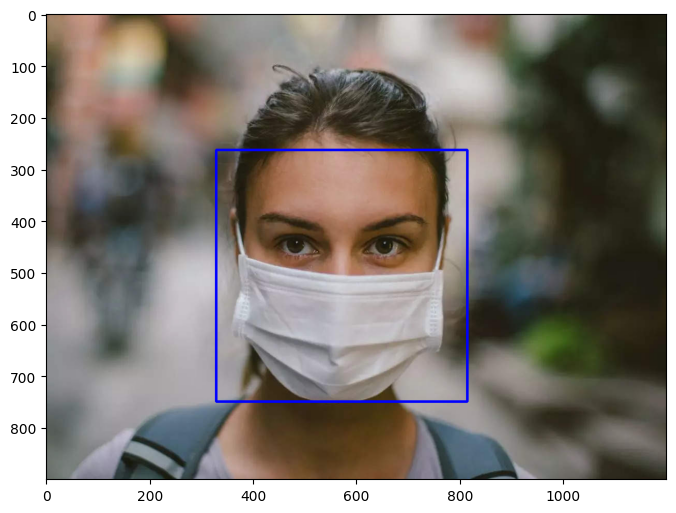

In [51]:
#trying it out on a sample image
img = cv2.imread('covid-face-mask.jpg')

img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4) #returns a list of (x,y,w,h) tuples

out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image

#plotting
for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),4)
plt.figure(figsize=(8,8))
plt.imshow(out_img)

In [17]:
MIN_DISTANCE = 130

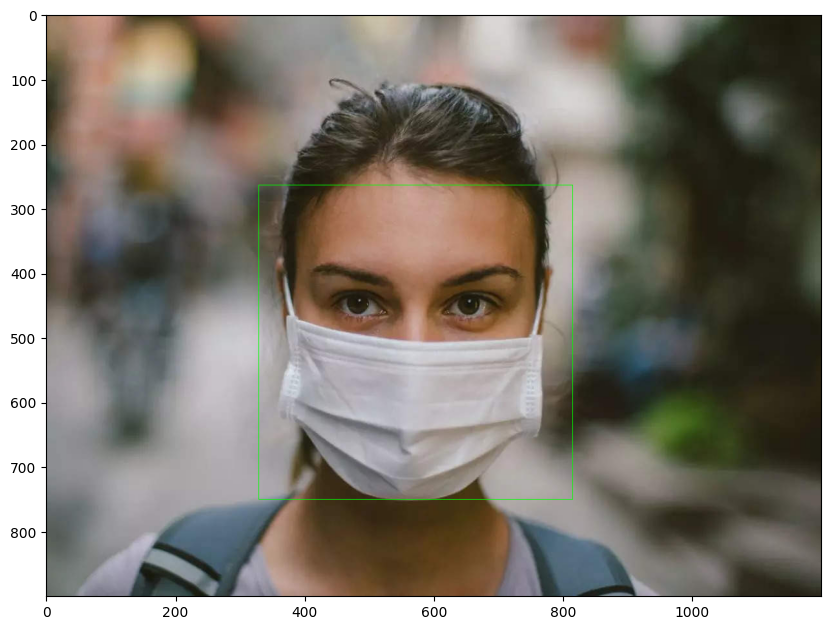

In [55]:
if len(faces)>0:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        if label[i]==1:
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(255,0,0),1)
        else:
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(0,255,0),1)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No. of faces detected is less than 2")
    

In [25]:
#Load train and test set
train_dir = 'C:/Users/abdel/MaskDL/Face Mask Dataset/Train'
test_dir = 'C:/Users/abdel/MaskDL/Face Mask Dataset/Test'
val_dir = 'C:/Users/abdel/MaskDL/Face Mask Dataset/Validation'

In [26]:
# Data augmentation

train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2,shear_range=0.2)
train_generator = train_datagen.flow_from_directory(directory=train_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

val_datagen = ImageDataGenerator(rescale=1.0/255)
val_generator = train_datagen.flow_from_directory(directory=val_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = train_datagen.flow_from_directory(directory=val_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [27]:
vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

for layer in vgg19.layers:
    layer.trainable = False
    
model = Sequential()
model.add(vgg19)
model.add(Flatten())
model.add(Dense(2,activation='sigmoid'))
model.summary()

80134624/80134624 [==============================] - 23s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 2)                 16386     
                                                                 
Total params: 20,040,770
Trainable params: 16,386
Non-trainable params: 20,024,384
_________________________________________________________________


In [28]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics ="accuracy")
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=len(train_generator)//32,
                              epochs=20,validation_data=val_generator,
                              validation_steps=len(val_generator)//32)

C:\Users\abdel\AppData\Local\Temp/ipykernel_12652/2707126020.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


Epoch 1/20
9/9 [==============================] - 20s 2s/step - loss: 0.4682 - accuracy: 0.7604
Epoch 2/20
9/9 [==============================] - 20s 2s/step - loss: 0.2366 - accuracy: 0.9201
Epoch 3/20
9/9 [==============================] - 20s 2s/step - loss: 0.1359 - accuracy: 0.9444
Epoch 4/20
9/9 [==============================] - 21s 2s/step - loss: 0.1518 - accuracy: 0.9375
Epoch 5/20
9/9 [==============================] - 20s 2s/step - loss: 0.1110 - accuracy: 0.9688
Epoch 6/20
9/9 [==============================] - 20s 2s/step - loss: 0.1103 - accuracy: 0.9583
Epoch 7/20
9/9 [==============================] - 20s 2s/step - loss: 0.1024 - accuracy: 0.9653
Epoch 8/20
9/9 [==============================] - 20s 2s/step - loss: 0.1046 - accuracy: 0.9653
Epoch 9/20
9/9 [==============================] - 20s 2s/step - loss: 0.0665 - accuracy: 0.9792
Epoch 10/20
9/9 [==============================] - 20s 2s/step - loss: 0.0731 - accuracy: 0.9757
Epoch 11/20
9/9 [======================

In [29]:
model.evaluate_generator(test_generator)

C:\Users\abdel\AppData\Local\Temp/ipykernel_12652/2205837447.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_generator)


[0.06896813958883286, 0.9725000262260437]

# Testing the model on the test data


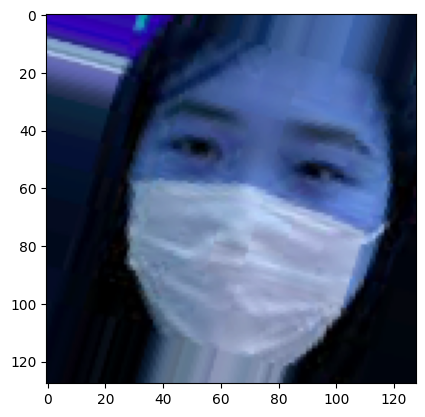

In [40]:
sample_mask_img = cv2.imread('Augmented_144_1849746.png')
sample_mask_img = cv2.resize(sample_mask_img,(128,128))
plt.imshow(sample_mask_img)
sample_mask_img = np.reshape(sample_mask_img,[1,128,128,3])
sample_mask_img = sample_mask_img/255.0

In [65]:
model.predict(sample_mask_img)[0]

1/1 [==============================] - 0s 74ms/step


array([0.9954527, 0.1072731], dtype=float32)

In [42]:
model.save('masknet.h5')

In [43]:
mask_label = {0:'MASK',1:'NO MASK'}
dist_label = {0:(0,255,0),1:(255,0,0)}

1/1 [==============================] - 0s 87ms/step


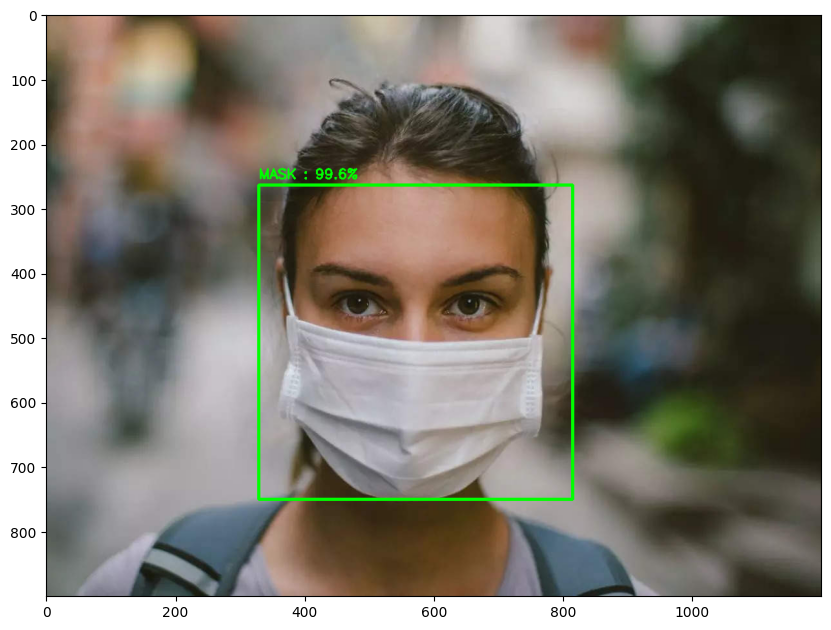

In [72]:
if len(faces)>0:
    label = [0 for i in range(len(faces))]
    for i in range(len(faces)-1):
        for j in range(i+1, len(faces)):
            dist = distance.euclidean(faces[i][:2],faces[j][:2])
            if dist<MIN_DISTANCE:
                label[i] = 1
                label[j] = 1
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = new_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(128,128))
        crop = np.reshape(crop,[1,128,128,3])/255.0
        mask_result = model.predict(crop)
        cv2.putText(new_img,f"{mask_label[mask_result.argmax()]} : {round(max(mask_result[0])*100,1)}%",(x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.7,dist_label[label[i]],2)
        cv2.rectangle(new_img,(x,y),(x+w,y+h),dist_label[label[i]],3)
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
            
else:
    print("No. of faces detected is less than 2")